# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [1]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True
USE_EVEN_NUMBER_OF_INPUT_ROWS = True
SEED_RANDOM_NUMBER_GENERATOR = True

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)



GENERATE = True, so we will generate new samples.


### Running PAC

In [2]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
if SEED_RANDOM_NUMBER_GENERATOR:
    np.random.seed(0)

import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator
from IPython.display import display, HTML

In [3]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [4]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
# drop last row
if USE_EVEN_NUMBER_OF_INPUT_ROWS:
    if por_df.shape[0] % 2 != 0:
        print(f"Input data has odd number of rows ({por_df.shape[0]}), dropping last row to make it even.")
        por_df = por_df.iloc[:-1]
por_df.shape

Input data has odd number of rows (649), dropping last row to make it even.


(648, 33)

In [5]:
por_df['absences'].count()

648

In [ ]:
### Query Setup
SAMPLES = 8192
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

OUTPUT_COLS = ['count', 'mean']
INPUT_COLS = ['count', 'mean']

true_result = por_df['absences'].agg(OUTPUT_COLS).to_numpy() # Save the true result of the query for later
#true_result = np.divide(true_result, 2) # manually correct count = count * 2
true_result[0] = true_result[0] / 2.   # manually correct count = count * 2
assert False # don't run blindly without considering if you need to remove this / it messes up DP error calculations too ^^^
number_of_contributing_rows = por_df['absences'].count()

def poisson_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select a subset of indices, where each index is selected with probability 0.5.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    mask = np.random.random_sample(len(df)) < 0.5  # Generates a bitmask of length df.shape[0] where each bit is 1 with probability 0.5
    selected = df[mask]
    not_selected = df[~mask]
    return selected, not_selected

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # Apply thresholding: if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)

    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    number_of_pairs = SAMPLES // 2
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        for temp_df in poisson_paired_sample(por_df):
            out_df = temp_df['absences'].agg(INPUT_COLS)  # run the query
            #out_df[0] = out_df[0] * 2   # manually correct count = count * 2
            out_np.append(out_df.to_numpy())

    return out_np

In [7]:
#s = generate_samples()
#s

#pd.DataFrame(s, columns=INPUT_COLS).hist("count")
#pd.DataFrame(s, columns=INPUT_COLS).hist("sum")
#pd.DataFrame(s, columns=INPUT_COLS).hist("mean")

In [8]:
# compute variance of pd.DataFrame(s, columns=INPUT_COLS)['sum']
#np.var(pd.DataFrame(s, columns=INPUT_COLS)['count'])

In [9]:
### Compute PAC Noise
def get_pac_noise_scale(out_np_raw: List[np.ndarray],
                           max_mi: float = 1./4) -> np.ndarray:
    if out_np_raw is None or len(out_np_raw) == 0:
        raise ValueError("Input list out_np cannot be empty.")
    out_np = out_np_raw.copy()
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, len(out_np))  # shape (dimensions, samples)
    #print(f"est_y.shape: {est_y.shape}")
    print(f"est_y: {est_y}")

    # get the scale in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    #print(f"fin_var: {fin_var}")
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))
    #print(f"sqrt_total_var: {sqrt_total_var}")

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
    print(f"For mi={max_mi}, we should add noise from a normal distribution with scale...")
    print(f"\t{1./(2*max_mi)} * {sqrt_total_var} * {np.sqrt(fin_var)} = {pac_noise}")
    #print(f"pac_noise: {pac_noise}")
    return pac_noise

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4,
                       variance: np.ndarray = None,
                       chosen_index: int = None) -> np.ndarray:
    
    if variance is not None:
        pac_noise: np.ndarray = variance
    else:
        pac_noise = get_pac_noise_scale(out_np, max_mi)

    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    if chosen_index is None:  # allow for overriding the chosen index to specify which sample to use for the release
        chosen_index = np.random.choice(range(SAMPLES))
    pac_release = out_np[chosen_index] + pac_noises_to_add
    
    return pac_release

In [10]:
# out_np = np.array([np.random.normal(loc=500, scale=10, size=8192),
#                    np.random.normal(loc=100, scale=5, size=8192),
#                    np.random.normal(loc=0, scale=200, size=8192)]).T.tolist()
# print("We have generated some fake data.")
# print(f"The standard deviation is {np.std(out_np, axis=0)}")
# print(f"The variance of the data is {np.var(out_np, axis=0)}")
# print(f"The mean of the data is {np.mean(out_np, axis=0)}")
# get_pac_noise_scale(out_np, 1./2)

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [11]:
MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]
EXPERIMENTS = 1000

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []
    saved_steps = []

    out_np = generate_samples() # generate samples (results of running the query)
    print(f"Generate samples... {len(out_np)} samples generated.")

    for mi in MI_OPTIONS:
        scale = get_pac_noise_scale(out_np, mi) # estimate the stability of the query
        #print(f"mi={mi}, scale={scale}")
        
        for e in range(EXPERIMENTS):
            # for each PAC release at this MI, we will choose a sample from the pre-generated out_np list and add noise to it
            steps = {
                "mi": mi,
                "variance": scale,
            }

            # choose our sample
            chosen_index = np.random.choice(range(SAMPLES))
            chosen_sample = out_np[chosen_index].copy()
            steps["chosen_sample"] = chosen_sample
            
            # add noise to it
            chosen_noise = np.random.normal(loc=0, scale=scale)
            steps["chosen_noise"] = chosen_noise

            release = chosen_sample + chosen_noise # do_pac_and_release(out_np, mi, variance, chosen_index)

            #print(f"sample(#{chosen_index}):{chosen_sample} + noise:{noise} = {noisy_output}")
            steps["release"] = release
            #release[0] *= 2   # manually correct count = count * 2

            # manually add sum as count * mean
            #noisy_output = [noisy_output[0], noisy_output[0] * noisy_output[1], noisy_output[1]]
            #chosen_sample = [chosen_sample[0], chosen_sample[0] * chosen_sample[1], chosen_sample[1]]
            experiment_results.append([mi, *release])
            saved_steps.append(steps)

        with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
            pickle.dump(experiment_results, f)
    
    df = pd.DataFrame(experiment_results, columns=['mi', *OUTPUT_COLS])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    # with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    # with open('{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

Generate samples... 8192 samples generated.
est_y: [[325.         323.         338.         ... 336.         319.
  329.        ]
 [  3.49230769   3.82662539   3.53254438 ...   3.39285714   3.55172414
    3.76291793]]
For mi=0.015625, we should add noise from a normal distribution with scale...
	32.0 * 12.833495508431865 * [12.65155198  0.18194353] = [5195.63633755   74.71908533]
est_y: [[325.         323.         338.         ... 336.         319.
  329.        ]
 [  3.49230769   3.82662539   3.53254438 ...   3.39285714   3.55172414
    3.76291793]]
For mi=0.03125, we should add noise from a normal distribution with scale...
	16.0 * 12.833495508431865 * [12.65155198  0.18194353] = [2597.81816877   37.35954267]
est_y: [[325.         323.         338.         ... 336.         319.
  329.        ]
 [  3.49230769   3.82662539   3.53254438 ...   3.39285714   3.55172414
    3.76291793]]
For mi=0.0625, we should add noise from a normal distribution with scale...
	8.0 * 12.833495508431865 * [

,mi,count,mean
0,0.015625,-758.173388,32.533504
1,0.015625,7793.970428,-1.664825
2,0.015625,-6957.817557,75.619238
3,0.015625,-6689.421112,63.076904
4,0.015625,4083.078435,-26.829720


In [12]:
saved_steps_df_temp = pd.DataFrame(saved_steps)
saved_steps_df_temp.head()

,mi,variance,chosen_sample,chosen_noise,release
0,0.015625,"[5195.63633754581, 74.7190853322965]","[325.0, 3.9046153846153846]","[-1083.1733884449523, 28.628888965155976]","[-758.1733884449523, 32.53350434977136]"
1,0.015625,"[5195.63633754581, 74.7190853322965]","[338.0, 3.6094674556213016]","[7455.9704283367455, -5.274292605873112]","[7793.9704283367455, -1.66482515025181]"
2,0.015625,"[5195.63633754581, 74.7190853322965]","[303.0, 3.5247524752475248]","[-7260.817557036067, 72.09448519564278]","[-6957.817557036067, 75.6192376708903]"
3,0.015625,"[5195.63633754581, 74.7190853322965]","[349.0, 3.5587392550143266]","[-7038.421112156452, 59.51816432591768]","[-6689.421112156452, 63.076903580932004]"
4,0.015625,"[5195.63633754581, 74.7190853322965]","[309.0, 3.841423948220065]","[3774.07843468119, -30.67114352781093]","[4083.07843468119, -26.829719579590865]"


In [13]:
### Reconstruct Saved Steps
# Get list of keys from the first dict, excluding 'mi' since it's not a list
steps = [k for k in saved_steps[0].keys() if k not in ('mi')] # pull keys from saved_steps[0]

saved_steps_df_temp = pd.DataFrame(saved_steps)

# Create expanded columns using comprehension
expanded = {
    'mi': saved_steps_df_temp['mi'],
    **{f'{step}_{col}': saved_steps_df_temp[step].str[i] 
        for step in steps
        for i, col in enumerate(OUTPUT_COLS)}
}

# Create MultiIndex DataFrame using OUTPUT_COLS
saved_steps_df = pd.DataFrame(expanded)
saved_steps_df.columns = pd.MultiIndex.from_tuples([('mi',''), *[  # multiindex so that we can do things like saved_steps_df['release'][<aggregation>]
    (step, col) for step in steps for col in OUTPUT_COLS
]], names=["step", "query"])
saved_steps_df.head()

step         mi     variance            chosen_sample           chosen_noise  \
query                  count       mean         count      mean        count   
0      0.015625  5195.636338  74.719085         325.0  3.904615 -1083.173388   
1      0.015625  5195.636338  74.719085         338.0  3.609467  7455.970428   
2      0.015625  5195.636338  74.719085         303.0  3.524752 -7260.817557   
3      0.015625  5195.636338  74.719085         349.0  3.558739 -7038.421112   
4      0.015625  5195.636338  74.719085         309.0  3.841424  3774.078435   

step                  release             
query       mean        count       mean  
0      28.628889  -758.173388  32.533504  
1      -5.274293  7793.970428  -1.664825  
2      72.094485 -6957.817557  75.619238  
3      59.518164 -6689.421112  63.076904  
4     -30.671144  4083.078435 -26.829720

In [14]:
saved_steps_df.groupby('mi').mean()

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_89398/2569112584.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df.groupby('mi').mean()


step          variance            chosen_sample           chosen_noise  \
query            count       mean         count      mean        count   
mi                                                                       
0.015625   5195.636338  74.719085       323.661  3.657692   241.912249   
0.031250   2597.818169  37.359543       323.260  3.657632   -25.396777   
0.062500   1298.909084  18.679771       323.591  3.658773    10.436617   
0.250000    324.727271   4.669943       324.129  3.651921     6.093617   
1.000000     81.181818   1.167486       323.985  3.651754     3.213500   
2.000000     40.590909   0.583743       324.336  3.657829     1.001636   
4.000000     20.295454   0.291871       323.497  3.660322    -0.585160   
16.000000     5.073864   0.072968       324.827  3.658896    -0.036598   

step                    release            
query          mean       count      mean  
mi                                         
0.015625   0.746548  565.573249  4.404239  
0.031250   0.840123  297.863223  4.497755  
0.062500  -0.064214  334.027617  3.594559  
0.250000  -0.010938  330.222617  3.640983  
1.000000   0.025645  327.198500  3.677399  
2.000000   0.020614  325.337636  3.678443  
4.000000  -0.003947  322.911840  3.656375  
16.000000  0.000082  324.790402  3.658978

Mean of chosen_sample['mean'] for mi = 1/32


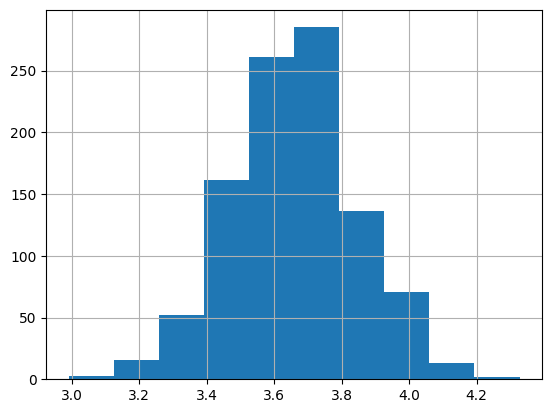

In [15]:
if ('mean' in OUTPUT_COLS):
    print("Mean of chosen_sample['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['chosen_sample']['mean'].hist()

Mean of release['mean'] for mi = 1/32


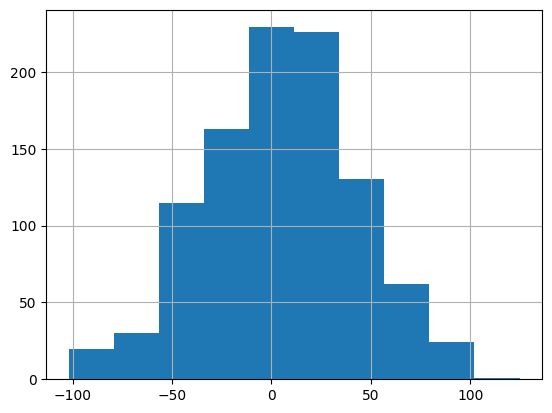

In [16]:
if ('mean' in OUTPUT_COLS):
    print("Mean of release['mean'] for mi = 1/32")
    saved_steps_df[saved_steps_df['mi'] == 1/32]['release']['mean'].hist()

In [17]:
### DEBUG: Save the variables from computing the PAC noises for later reverse engineering
#if GENERATE:
#    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['mi', 'out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
#    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
#else:
#    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
#saved_pac_variables_df.head()

### Computing PAC Errors

In [18]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [19]:
#OUTPUT_COLS = OUTPUT_COLS
ERROR_COLS = [*[f'absolute error {i}' for i in OUTPUT_COLS], *[f'relative error {i}' for i in OUTPUT_COLS]]

In [20]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error mean,relative error count,relative error mean
0,0.015625,1082.173388,28.874554,334.004132,789.148495
1,0.015625,7469.970428,5.323776,2305.546428,145.500072
2,0.015625,7281.817557,71.960287,2247.474555,1966.691945
3,0.015625,7013.421112,59.417953,2164.636146,1623.906939
4,0.015625,3759.078435,30.488670,1160.209393,833.262686
...,...,...,...,...,...
7995,16.000000,23.949980,0.179104,7.391969,4.894944
7996,16.000000,12.775284,0.020693,3.942989,0.565552
7997,16.000000,26.593800,0.164429,8.207963,4.493896
7998,16.000000,8.774696,0.114350,2.708239,3.125208


In [21]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Computing DP Errors

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [22]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp_results.parquet").to_pandas()

# compute sum from count and mean
dp_results_df['sum'] = dp_results_df['count'] * dp_results_df['mean']
dp_results_df = dp_results_df[['mi', 'count', 'sum', 'mean']]

# filter to just MI_OPTIONS
dp_results_df = dp_results_df[dp_results_df['mi'].isin(MI_OPTIONS)]

dp_results_df

,mi,count,sum,mean
200,0.015625,648.722920,2155.379932,3.322497
201,0.015625,648.527764,2312.631388,3.565971
202,0.015625,651.574787,2350.085033,3.606777
203,0.015625,649.126934,2375.476365,3.659494
204,0.015625,652.777399,2432.672697,3.726650
...,...,...,...,...
895,16.000000,648.910033,2374.250822,3.658829
896,16.000000,649.067287,2372.422164,3.655125
897,16.000000,648.942620,2367.126350,3.647667
898,16.000000,649.044352,2379.478704,3.666127


In [23]:
# compute errors for DP (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        mi = row['mi']
        r = row[OUTPUT_COLS].to_numpy()
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['mi', *ERROR_COLS])
    dp_errors_df.to_parquet(f"outputs/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"outputs/dp_errors.parquet").to_pandas()
dp_errors_df

,mi,absolute error count,absolute error mean,relative error count,relative error mean
0,0.015625,324.722920,0.336454,100.223123,9.195359
1,0.015625,324.527764,0.092979,100.162890,2.541147
2,0.015625,327.574787,0.052173,101.103329,1.425914
3,0.015625,325.126934,0.000544,100.347819,0.014861
4,0.015625,328.777399,0.067699,101.474506,1.850232
...,...,...,...,...,...
695,16.000000,324.910033,0.000122,100.280874,0.003325
696,16.000000,325.067287,0.003825,100.329410,0.104551
697,16.000000,324.942620,0.011284,100.290932,0.308394
698,16.000000,325.044352,0.007176,100.322331,0.196119


In [24]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    dp_results_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
#all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")  # Save the merged results
all_df

count mean     count var     sum mean       sum var  \
type factor                                                           
dp   0.015625   649.211672  1.530226e+01  2393.518288  15896.159336   
     0.062500   649.249789  5.904308e+00  2378.577932   3755.535957   
     0.250000   649.049285  7.038266e-01  2372.398562    807.714716   
     1.000000   648.998183  1.466184e-02  2375.337267     17.589852   
     2.000000   649.007585  2.109847e-02  2375.221984     20.881309   
     4.000000   648.991005  1.273822e-02  2375.038740     15.952673   
     16.000000  649.011175  1.554098e-02  2375.139964     17.884501   
pac  0.015625   565.573249  2.602249e+07          NaN           NaN   
     0.031250   297.863223  7.077860e+06          NaN           NaN   
     0.062500   334.027617  1.670614e+06          NaN           NaN   
     0.250000   330.222617  1.066862e+05          NaN           NaN   
     1.000000   327.198500  7.244926e+03          NaN           NaN   
     2.000000   325.337636  1.794020e+03          NaN           NaN   
     4.000000   322.911840  6.005692e+02          NaN           NaN   
     16.000000  324.790402  1.944333e+02          NaN           NaN   

                mean mean     mean var  
type factor                             
dp   0.015625    3.686918     0.038056  
     0.062500    3.663558     0.008563  
     0.250000    3.655199     0.001959  
     1.000000    3.660006     0.000042  
     2.000000    3.659775     0.000048  
     4.000000    3.659587     0.000038  
     16.000000   3.659629     0.000041  
pac  0.015625    4.404239  5790.906954  
     0.031250    4.497755  1450.360671  
     0.062500    3.594559   329.922499  
     0.250000    3.640983    20.176453  
     1.000000    3.677399     1.523331  
     2.000000    3.678443     0.377785  
     4.000000    3.656375     0.112005  
     16.000000   3.658978     0.034629

In [25]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    #dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    dp_errors_df.assign(type='dp').rename(columns={'mi': 'factor'}),
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
#errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

#errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error count mean  absolute error count var  \
type factor                                                           
dp   0.015625                  325.211672              1.530226e+01   
     0.062500                  325.249789              5.904308e+00   
     0.250000                  325.049285              7.038266e-01   
     1.000000                  324.998183              1.466184e-02   
     2.000000                  325.007585              2.109847e-02   
     4.000000                  324.991005              1.273822e-02   
     16.000000                 325.011175              1.554098e-02   
pac  0.015625                 4130.095686              9.006144e+06   
     0.031250                 2129.550313              2.539020e+06   
     0.062500                 1040.890801              5.861766e+05   
     0.250000                  264.795915              3.653790e+04   
     1.000000                   67.410404              2.706456e+03   
     2.000000                   33.705849              6.585898e+02   
     4.000000                   19.499727              2.211345e+02   
     16.000000                  11.094551              7.184641e+01   

                absolute error mean mean  absolute error mean var  \
type factor                                                         
dp   0.015625                   0.138462                 0.019481   
     0.062500                   0.065409                 0.004262   
     0.250000                   0.031572                 0.000967   
     1.000000                   0.004667                 0.000021   
     2.000000                   0.004833                 0.000025   
     4.000000                   0.004739                 0.000016   
     16.000000                  0.004769                 0.000019   
pac  0.015625                  60.694843              2103.911415   
     0.031250                  30.665599               509.744670   
     0.062500                  14.452661               120.838142   
     0.250000                   3.517877                 7.788931   
     1.000000                   0.996848                 0.528972   
     2.000000                   0.493009                 0.134864   
     4.000000                   0.267387                 0.040445   
     16.000000                  0.147802                 0.012761   

                relative error count mean  relative error count var  \
type factor                                                           
dp   0.015625                  100.373973                  1.457692   
     0.062500                  100.385737                  0.562444   
     0.250000                  100.323854                  0.067046   
     1.000000                  100.308081                  0.001397   
     2.000000                  100.310983                  0.002010   
     4.000000                  100.305866                  0.001213   
     16.000000                 100.312091                  0.001480   
pac  0.015625                 1274.720891             857924.072814   
     0.031250                  657.268615             241866.734868   
     0.062500                  321.262593              55839.102694   
     0.250000                   81.727134               3480.595428   
     1.000000                   20.805680                257.816602   
     2.000000                   10.403040                 62.737177   
     4.000000                    6.018434                 21.065244   
     16.000000                   3.424244                  6.844080   

                relative error mean mean  relative error mean var  
type factor                                                        
dp   0.015625                   3.784209             1.455119e+01  
     0.062500                   1.787633             3.183801e+00  
     0.250000                   0.862863             7.220235e-01  
     1.000000                   0.127540             1.557528e-02  
     2.000000     

In [26]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [27]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [28]:
import matplotlib.colors as mcolors

PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# Function to lighten a color by blending with white
def lighten_color(color, amount=0.3):
    rgba = mcolors.to_rgba(color)
    return tuple(np.clip(np.array(rgba[:3]) + amount, 0, 1)) + (rgba[3],)

# Create lighter colors
PAC_LIGHT = lighten_color(PAC_COLOR, 0.3)
DP_LIGHT = lighten_color(DP_COLOR, 0.3)

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

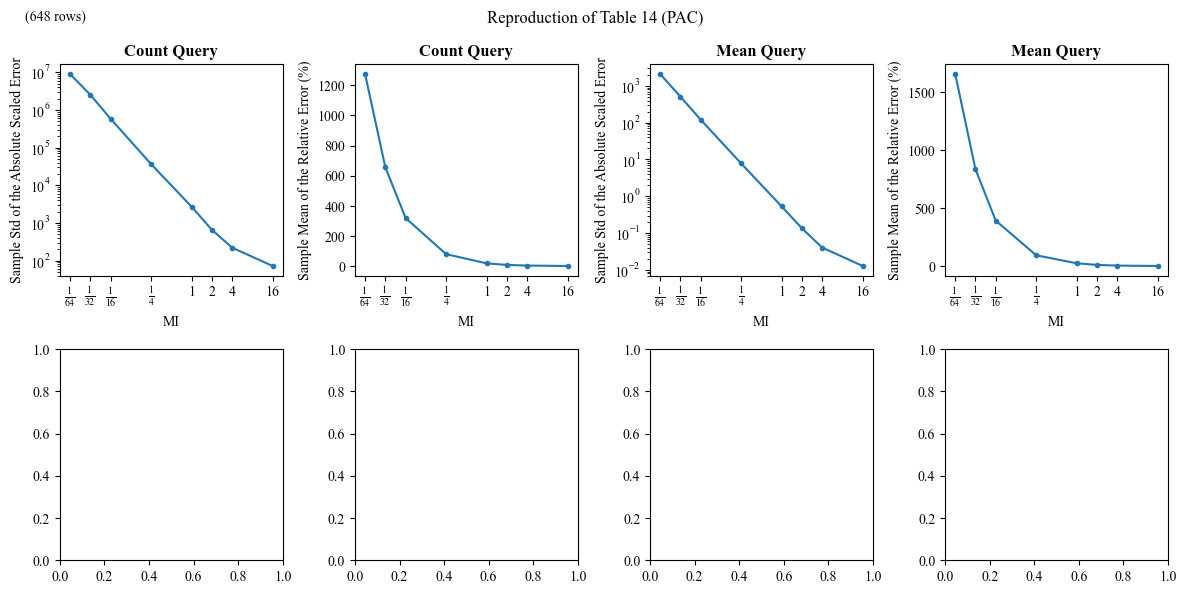

In [29]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')

    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.95, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

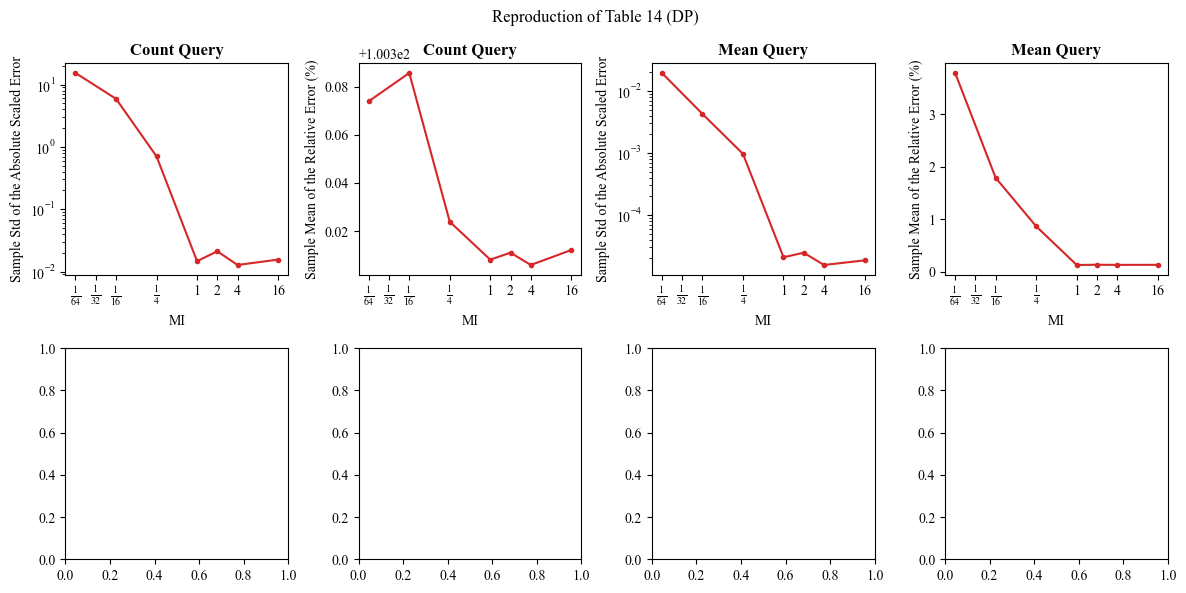

In [30]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    
    ax1.set_yscale('log')

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

Both on the same axes, aligned

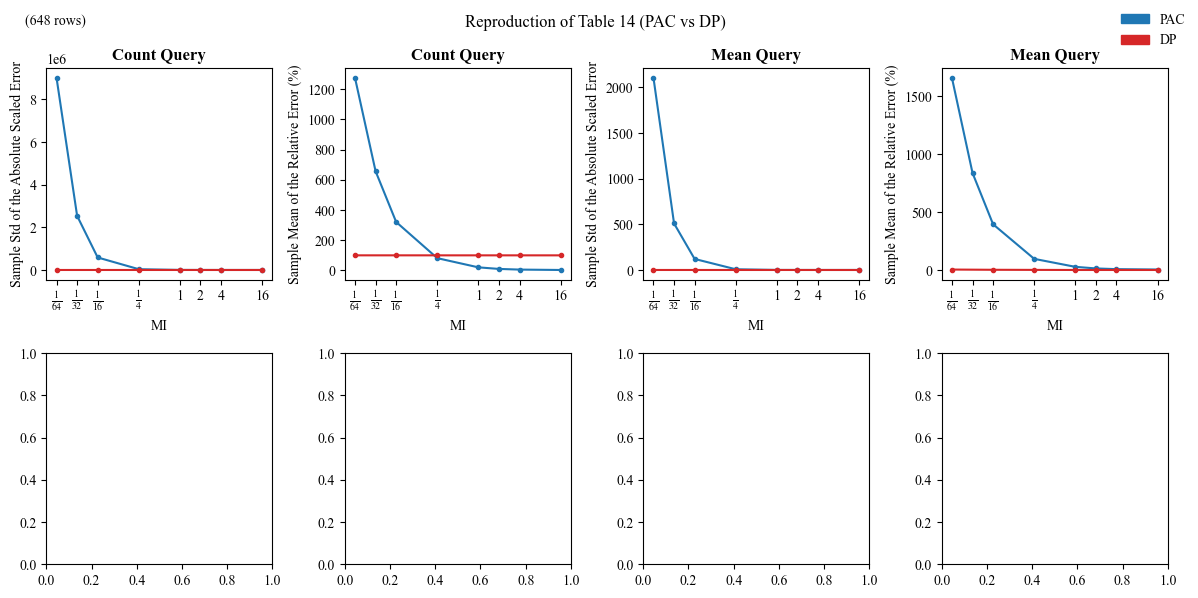

In [31]:
### Both on the same axes, aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    #print(d)
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xlabels)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('MI')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    
    ax2.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('MI')

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

# Additonal Extra Plotting

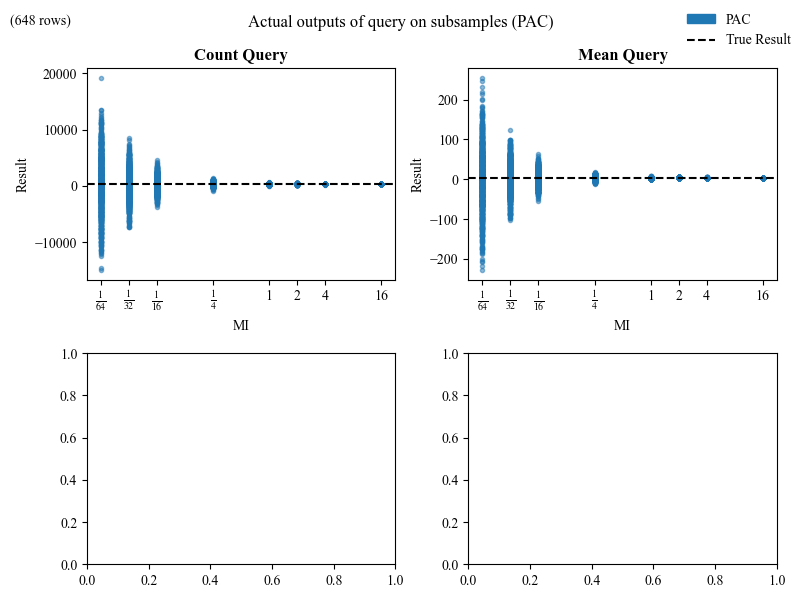

In [32]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'pac'
    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

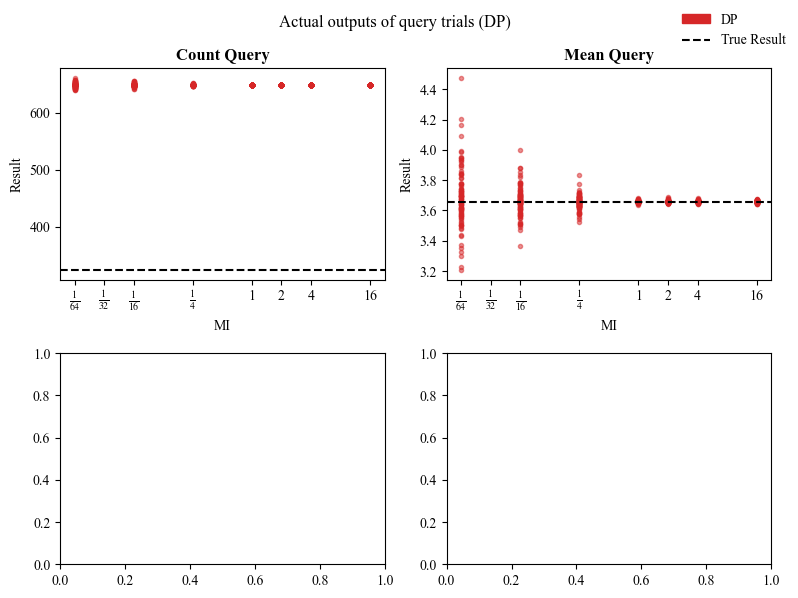

In [33]:
### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    TYPE = 'dp'

    ax.scatter(dp_results_df['mi'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

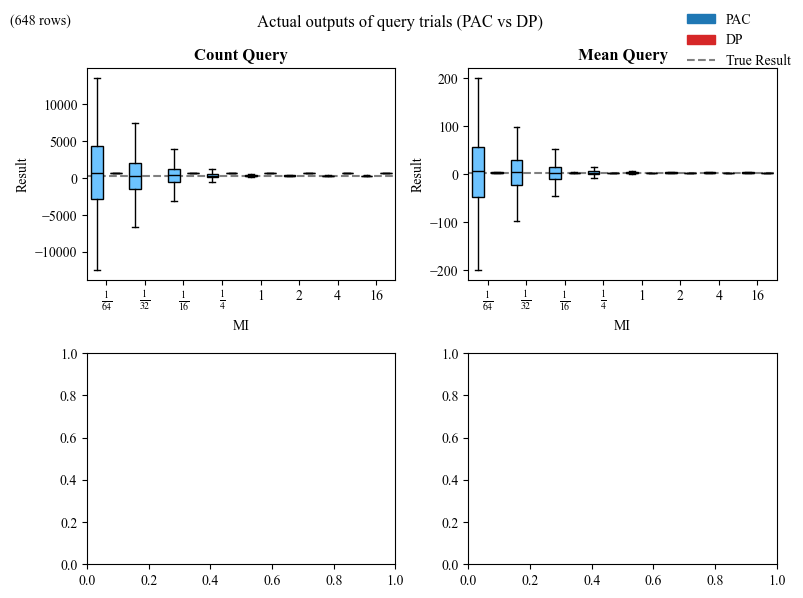

In [34]:
### Both, but with side by side fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = OUTPUT_COLS
#MI_OPTIONS = [1/256, 1/128, 1/64, 1/32, 1/16, 1/4, 1., 2., 4., 16.]

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.linewidth = 0.25

    # correct answer
    ax.axhline(y=true_result[i], color='gray', linestyle='--', label='True Result')

    for mi in MI_OPTIONS: # categorical variable
        position = MI_OPTIONS.index(mi) * 2

        TYPE = 'pac'

        pac_style = {
            'boxprops': dict(facecolor=PAC_LIGHT),
            'medianprops': dict(color='black')
        }
        
        # mi = mi and query is correct
        d = df[df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **pac_style)

        position += 1
        TYPE = 'dp'

        dp_style = {
            'boxprops': dict(facecolor=DP_LIGHT),
            'medianprops': dict(color='black')
        }

        # mi = mi and query is correct
        d = dp_results_df[dp_results_df['mi'] == mi][query].values
        ax.boxplot(d, positions=[position], widths=0.6, patch_artist=True, showfliers=False, **dp_style)
    
    
    
    # override xticks, one for each pair of boxplots
    # the x axis is actually artificial here to plot both PAC and DP side by side
    xticks = [0.5+2*i for i in range(len(MI_OPTIONS))]
    ax.set_xticks(xticks)

    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in MI_OPTIONS]
    ax.set_xticklabels(xlabels)

    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='gray', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
#fig.text(0.75, 0.94, '(sum = count * mean)', ha='center', va='center')
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("Actual outputs of query trials (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp_vs_pac.jpg", bbox_inches='tight')
plt.show()


In [35]:
df.groupby('mi').var()

,count,mean
mi,,
0.015625,2.602249e+07,5790.906954
0.031250,7.077860e+06,1450.360671
0.062500,1.670614e+06,329.922499
0.250000,1.066862e+05,20.176453
1.000000,7.244926e+03,1.523331
2.000000,1.794020e+03,0.377785
4.000000,6.005692e+02,0.112005
16.000000,1.944333e+02,0.034629


In [36]:
print("Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)")
saved_steps_df[['mi','variance']].groupby('mi').mean()

Scale of noise added to [Count, Mean] (scale param passed to Normal noise function)


step          variance           
query            count       mean
mi                               
0.015625   5195.636338  74.719085
0.031250   2597.818169  37.359543
0.062500   1298.909084  18.679771
0.250000    324.727271   4.669943
1.000000     81.181818   1.167486
2.000000     40.590909   0.583743
4.000000     20.295454   0.291871
16.000000     5.073864   0.072968

Comparison of how much noise is added to the data, by looking at the variance of the distributions from which noise is sampled.

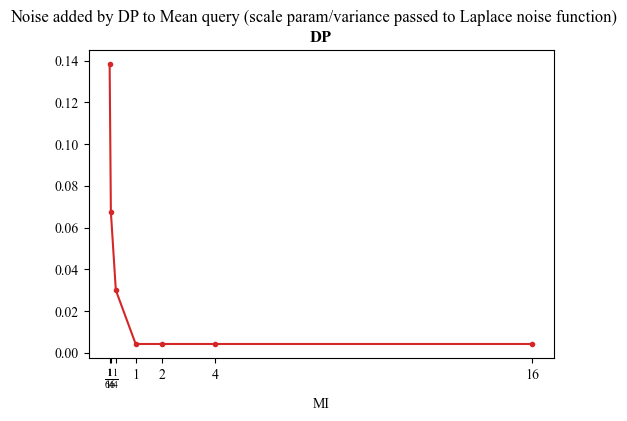

In [37]:
dp_var_noise = {  # from pipelinedp repo, dp_basic_mean_variances.csv
    #0.00390625: 0.2784089313555703,
    #0.0078125: 0.19648087910574175,
    0.015625: 0.13837628104247293,
    0.0625: 0.06750340282072995,
    0.25: 0.03001721300521553,
    1.0: 0.004282722801885366,
    2.0: 0.004282722801885366,
    4.0: 0.004282722801885366,
    16.0: 0.004282722801885366
}
d = dp_var_noise
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.plot(d.keys(), d.values(), marker='.', label='DP', color=DP_COLOR)
plt.xlabel('MI')
ax.set_xticks(list(d.keys()))
ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
plt.suptitle('Noise added by DP to Mean query (scale param/variance passed to Laplace noise function)')
plt.title('DP')
plt.savefig(f"{OUTPUT_DIR}/noise_distribution_variance_meanquery_dp.jpg", bbox_inches='tight')
plt.show()

In [38]:
#assert not any(any(saved_steps_df[['mi','variance']].groupby('mi').var().values)) # assume we are only computing variance once per MI
if ('mean' in OUTPUT_COLS):
    pac_var_noise = dict(zip(MI_OPTIONS, saved_steps_df[['mi','variance']].groupby('mi').mean()[[('variance','mean')]].to_numpy().flatten()))
    pac_var_noise

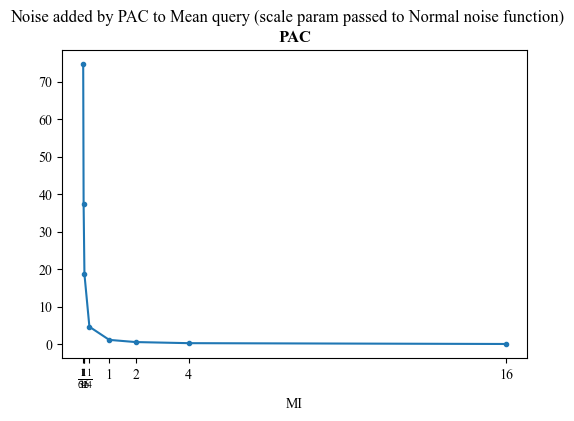

In [39]:
# Let's compute the same for PAC: what is the variance of the distribution from which noise is sampled to add to PAC?
if ('mean' in OUTPUT_COLS): 
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    d = pac_var_noise
    plt.plot(d.keys(), d.values(), marker='.', label='PAC', color=PAC_COLOR)
    plt.xlabel('MI')
    ax.set_xticks(list(d.keys()))
    ax.set_xticklabels([f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in d.keys()])
    plt.suptitle('Noise added by PAC to Mean query (scale param passed to Normal noise function)')
    plt.title('PAC')
    plt.savefig(f"{OUTPUT_DIR}/noise_distribution_variance_meanquery_pac.jpg", bbox_inches='tight')
    plt.show()

In [40]:
# How much of PAC error is due to sampling? Compute % error on our samples before noise was added
sample_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()]
sample_errors_df = pd.DataFrame(sample_errors, columns=OUTPUT_COLS)
sample_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Error from Subsampling (as % of true_result, without any noise being added)")
#print("First output: overall mean / Second output: grouped by MI")
display(sample_errors_df[OUTPUT_COLS].mean())
display(sample_errors_df.groupby('mi').mean())

PAC: Error from Subsampling (as % of true_result, without any noise being added)


count    3.104012
mean     3.951431
dtype: float64

,count,mean
mi,,
0.015625,3.098457,4.043943
0.031250,3.130247,4.089253
0.062500,2.979938,3.907815
0.250000,3.066358,3.915790
1.000000,3.150926,3.990427
2.000000,3.063580,3.932956
4.000000,3.137346,3.929540
16.000000,3.205247,3.801720


In [41]:
print("PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)")
# abs before mean
saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})

PAC: How much noise are we adding? (actual noise amounts sampled from the normal distribution, absolute value)


/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_89398/2429859456.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  saved_steps_df[['mi', 'chosen_noise']].apply(lambda x: np.abs(x)).groupby('mi').mean().rename(columns={'chosen_noise': 'abs(chosen_noise)'})


step      abs(chosen_noise)           
query                 count       mean
mi                                    
0.015625        4130.658686  60.699121
0.031250        2129.783407  30.672856
0.062500        1040.551728  14.448903
0.250000         264.034891   3.515455
1.000000          67.373660   0.990685
2.000000          31.430899   0.478550
4.000000          16.999806   0.227987
16.000000          3.976865   0.059858

In [42]:
print("Avg. value of unnoised sample used by PAC")
display(saved_steps_df[['chosen_sample']].mean().to_frame(name='all mi').T)  # sample shouldn't change with MI, so we can find the overall average
display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different

Avg. value of unnoised sample used by PAC


step   chosen_sample          
query          count      mean
all mi     323.91075  3.656852

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_89398/438083709.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  display(saved_steps_df[['mi', 'chosen_sample']].groupby('mi').mean())  # average per MI, shouldn't be different


step      chosen_sample          
query             count      mean
mi                               
0.015625        323.661  3.657692
0.031250        323.260  3.657632
0.062500        323.591  3.658773
0.250000        324.129  3.651921
1.000000        323.985  3.651754
2.000000        324.336  3.657829
4.000000        323.497  3.660322
16.000000       324.827  3.658896

In [43]:
# How much total error is there in PAC? Compute % error on our samples after noise was added
total_errors = [relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]
total_errors_df = pd.DataFrame(total_errors, columns=OUTPUT_COLS)
total_errors_df.insert(0, 'mi', saved_steps_df['mi'].values)  # Insert 'mi' at the beginning
print("PAC: Total Error (as % of true_result)")
total_errors_df.groupby('mi').mean()

PAC: Total Error (as % of true_result)


,count,mean
mi,,
0.015625,1274.720891,1658.804658
0.031250,657.268615,838.098200
0.062500,321.262593,394.994707
0.250000,81.727134,96.144418
1.000000,20.805680,27.244082
2.000000,10.403040,13.474052
4.000000,6.018434,7.307749
16.000000,3.424244,4.039453


In [44]:
print("PAC: Increase in Avg. % error due to noise being added (as % of true_result)")
delta_error_from_noise = pd.concat(
    [
        saved_steps_df['mi'].reset_index(drop=True),
        pd.DataFrame(
            (np.array([relative_error_percent(s, true_result) for s in saved_steps_df['release'].to_numpy()]) -
             np.array([relative_error_percent(s, true_result) for s in saved_steps_df['chosen_sample'].to_numpy()])),
            columns=OUTPUT_COLS
        )
    ],
    axis=1
)
delta_error_from_noise.groupby('mi').mean()

PAC: Increase in Avg. % error due to noise being added (as % of true_result)


,count,mean
mi,,
0.015625,1271.622434,1654.760715
0.031250,654.138368,834.008946
0.062500,318.282655,391.086893
0.250000,78.660776,92.228628
1.000000,17.654754,23.253655
2.000000,7.339459,9.541096
4.000000,2.881089,3.378209
16.000000,0.218997,0.237733


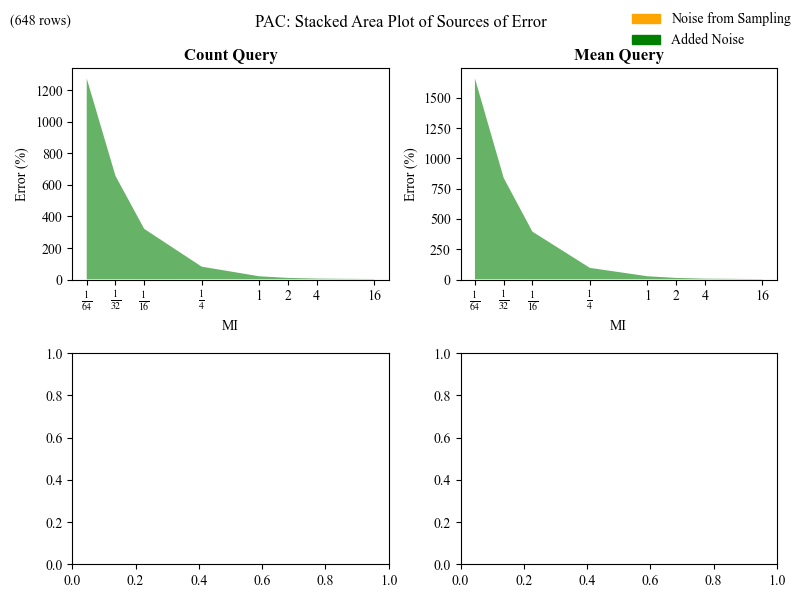

In [45]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

psample_errors = sample_errors_df.groupby('mi').mean()
pnoise_errors = delta_error_from_noise.groupby('mi').mean()

for i, query in enumerate(OUTPUT_COLS):
    row = i//2
    col = i%2
    ax = axs[row][col]

    ax.stackplot(psample_errors.index, psample_errors[query], pnoise_errors[query], 
        labels=['Sample Error', 'Noise Error'], colors=['orange', 'green'], alpha=0.6)
    
    ax.set_xscale('log', base=2)
    xticks = MI_OPTIONS
    xlabels = [f'$\\frac{{1}}{{{int(1/x)}}}$' if x < 1 else f'{int(x)}' for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)


    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Error (%)')

fig.legend(handles=[
    Patch(facecolor='orange', edgecolor='orange', label='Noise from Sampling'),
    Patch(facecolor='green', edgecolor='green', label='Added Noise'),
], loc='upper right', frameon=False)

# add label in top left corner "sum = count * mean"
fig.text(0.05, 0.97, f'({por_df.shape[0]} rows)', ha='center', va='center')
fig.suptitle("PAC: Stacked Area Plot of Sources of Error")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/pac_error_breakdown.jpg", bbox_inches='tight')
plt.show()